In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,precision_score,recall_score, confusion_matrix,f1_score,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

## LOADING THE DATASET 

In [2]:
csv_file = "mutagenicity.csv"  ; 
mutagen_df = pd.read_csv(csv_file);
print(mutagen_df.head()) ; 

   Unnamed: 0  Id       CAS                     SMILES    Status  \
0           0   1  100-00-5   O=[N+]([O-])c1ccc(cc1)Cl  Training   
1           1   2  100-01-6    O=[N+]([O-])c1ccc(N)cc1  Training   
2           2   3  100-02-7    O=[N+]([O-])c1ccc(O)cc1  Training   
3           3   4  100-11-8  O=[N+]([O-])c1ccc(cc1)CBr  Training   
4           4   5  100-12-9   O=[N+]([O-])c1ccc(cc1)CC  Training   

   Experimental value Predicted value  NumValenceElectrons       qed   TPSA  \
0                   1               1                   52  0.463602  43.14   
1                   1               1                   52  0.359544  69.16   
2                   0               1                   52  0.470728  63.37   
3                   1               0                   58  0.432586  43.14   
4                   0               0                   58  0.479785  43.14   

     MolMR  BalabanJ     BertzCT    MolWt  MolLogP  
0  38.1064  3.003401  244.429658  157.556   2.2482  
1  37.5088

## Checking for missing values

In [3]:
print("Missing values in each column:\n",mutagen_df.isnull().sum()) ; 

Missing values in each column:
 Unnamed: 0             0
Id                     0
CAS                    0
SMILES                 0
Status                 0
Experimental value     0
Predicted value        0
NumValenceElectrons    0
qed                    0
TPSA                   0
MolMR                  0
BalabanJ               0
BertzCT                0
MolWt                  0
MolLogP                0
dtype: int64


#### As there are no missing values we need not handle them explicitly.

## Making and displaying the correlation matrix 

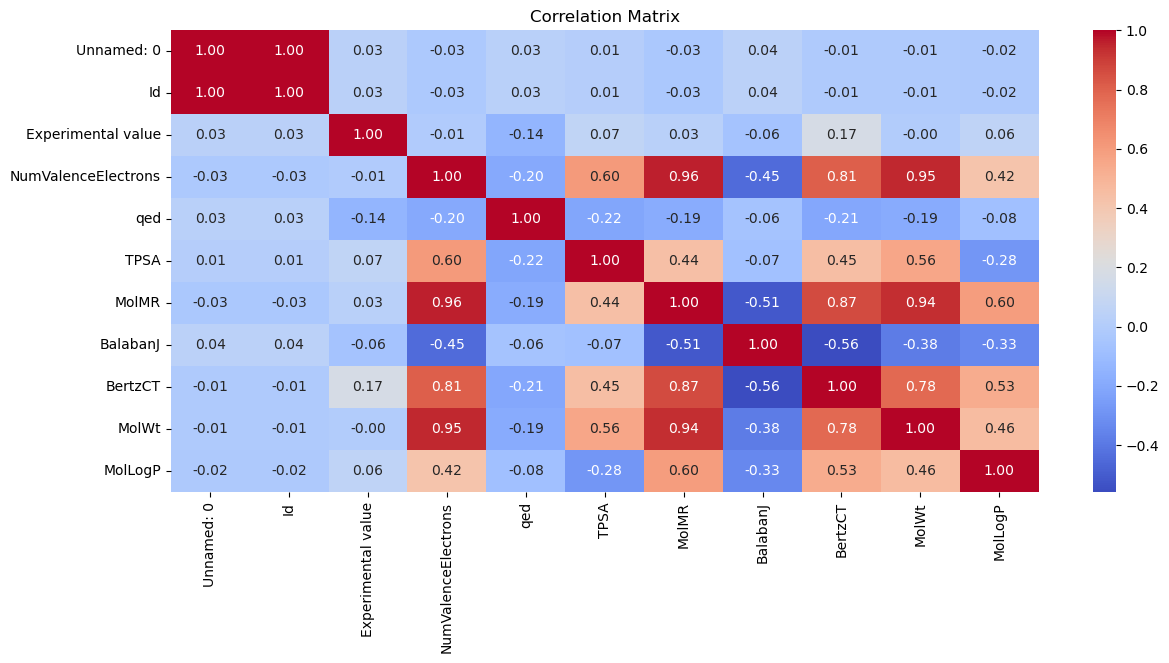

In [4]:
numeric_df = mutagen_df.select_dtypes(include=[np.number]);
corr_matrix = numeric_df.corr() ; 
plt.figure(figsize=(14,6)) ;
sns.heatmap(corr_matrix,annot=True, fmt=".2f",cmap="coolwarm") ; 
plt.title("Correlation Matrix") ; 
plt.show() ; 


#### We can see that the properties from NumValence electrons to MolLogP are well correlated so we might want to use them as features

## SPLITTING THE DATASET INTO FEATURES AND TARGETS

#### We will use Experimental values as our Target and Properties from NumValence electrons to MolLogP as features.

In [5]:
# Defining the features and targets
X = mutagen_df.loc[:,'NumValenceElectrons':'MolLogP'].values ; 
y = mutagen_df['Experimental value'].values  ; 

scaler = StandardScaler() ; 
X = scaler.fit_transform(X)  ; 

# Spliting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42) ; 

## APPLICATION OF KNN MODEL

In [6]:
# Defining the kNN model and hyperparameter grid for optimization of k
knn = KNeighborsClassifier() ; 

# Hyperparameter grid for KNeighborsClassifier
param_grid = {
    'n_neighbors': range(1, 21),  # k values from 1 to 20
    'weights': ['uniform','distance'],  # 'uniform' or 'distance' weighting
    'metric': ['euclidean','manhattan', 'minkowski'],  # Distance metrics
    'algorithm': ['ball_tree','kd_tree','brute']  # Algorithms for nearest neighbors search
}

# Performing GridSearchCV to find the best combination of parameters
grid_search = GridSearchCV(knn, param_grid,scoring='f1',cv=5,verbose=1,n_jobs=-1) ; 
grid_search.fit(X_train,y_train) ; 

# Getting the best parameters and model
best_params = grid_search.best_params_ ; 
print(f"Best Parameters: {best_params}");
best_knn = grid_search.best_estimator_ ; 

# Evaluating the model 
y_pred = best_knn.predict(X_test) ; 

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Parameters: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'distance'}


## EVALUATION OF THE MODEL 

F1-Score on Test Set: 0.7594
Accuracy: 0.7268
Precision: 0.7542
Recall: 0.7646


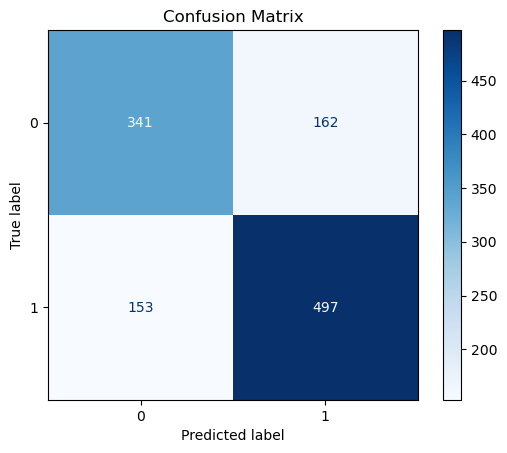


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.68       503
           1       0.75      0.76      0.76       650

    accuracy                           0.73      1153
   macro avg       0.72      0.72      0.72      1153
weighted avg       0.73      0.73      0.73      1153



In [7]:
# F1-Score
f1 = f1_score(y_test,y_pred) ; 
print(f"F1-Score on Test Set: {f1:.4f}") ; 

# Accuracy, Precision, and Recall scores
accuracy = accuracy_score(y_test,y_pred) ; 
precision = precision_score(y_test, y_pred) ; 
recall = recall_score(y_test, y_pred) ; 

print(f"Accuracy: {accuracy:.4f}") ; 
print(f"Precision: {precision:.4f}") ; 
print(f"Recall: {recall:.4f}")  ;

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_knn, X_test, y_test, cmap='Blues') ;
plt.title("Confusion Matrix") ; 
plt.show() ;

# Classification report
print("\nClassification Report:") ; 
print(classification_report(y_test, y_pred)) ; 